So far we have been looking at some of the basic tools provided with the AMUSE framework. These tools are generally useful but mainly meant to ease working with *community* codes. *Community* codes form the core of the AMUSE framework and are the functional components to evolve astrophysical models in time or calculate properties of the physical models.

*Community* codes are existing and newly developed applications, implemented in C/C++ or Fortran. The AMUSE framework provides an interface to these codes so that you can interact with every code in a standard way.



In [1]:
from amuse.lab import *

For example, we can calculate the HR diagram of a star by first creating a stellar evolution code.

In [2]:
code = SeBa()
print code

The interface to a *Community* code is implemented as a class with a name based on the name of the original application. In this case we will use SeBa, a stellar evolution code based on precalculated tracks.

Every code in amuse supports particle collections or grids. SeBa supports two particle collections, one for single stars (called `particles`) and one for binaries (called `binaries`). We will add a particle to the single stars collection.

In [6]:
code.particles.add_particle(Particle(mass = 2 | units.MSun))
print code.particles

                 key  CO_core_mass          age  convective_envelope_mass  convective_envelope_radius    core_mass  core_radius  effective_radius  envelope_mass  gyration_radius_sq   luminosity         mass  natal_kick_x  natal_kick_y  natal_kick_z       radius  relative_age  relative_mass  stellar_type  temperature    time_step  wind_mass_loss_rate
                   -         MSun          Myr         MSun         RSun         MSun         RSun         RSun         MSun         none         LSun         MSun          kms          kms          kms         RSun          Myr         MSun  stellar_type            K          Myr    MSun / yr
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
 9365612966911695680    0.000e+00    0.000e+00    0.000e+00

Next, we will evolve the code over 1 billion year and store the luminosity and temperature as time goes

In [13]:
import numpy as np

In [14]:
luminosity = [] | units.LSun
temperature = [] | units.K

t = 0 | units.Myr
while t < 2 | units.Gyr:
    t += 5 | units.Myr
    code.evolve_model(t)
    luminosity.append(code.particles[0].luminosity)
    temperature.append(code.particles[0].temperature)
    if np.mod(t, 100 | units.Myr) == (0 | units.yr):
        print "evolved untile time ", t

evolved untile time  100.0 Myr
evolved untile time  200.0 Myr
evolved untile time  300.0 Myr
evolved untile time  400.0 Myr
evolved untile time  500.0 Myr
evolved untile time  600.0 Myr
evolved untile time  700.0 Myr
evolved untile time  800.0 Myr
evolved untile time  900.0 Myr
evolved untile time  1000.0 Myr
evolved untile time  1100.0 Myr
evolved untile time  1200.0 Myr
evolved untile time  1300.0 Myr
evolved untile time  1400.0 Myr
evolved untile time  1500.0 Myr
evolved untile time  1600.0 Myr
evolved untile time  1700.0 Myr
evolved untile time  1800.0 Myr
evolved untile time  1900.0 Myr
evolved untile time  2000.0 Myr


After evolving we can save the data or plot it if we want.

In [16]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


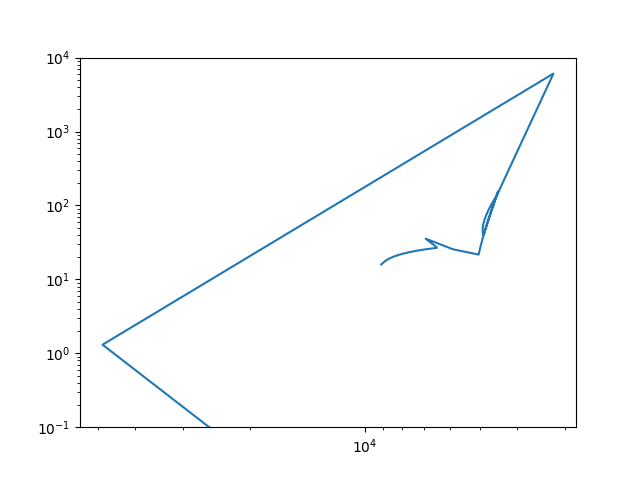

(0.1, 10000.0)

In [20]:
plt.loglog(temperature.value_in(units.K), luminosity.value_in(units.LSun))
plt.xlim(plt.xlim()[::-1])
plt.ylim(.1,1.e4)

Now we are done, and need to stop the code. After stopping the code we cannot interact with it any longer and requesting any particle attributes of the particles in the code will result in an error. 

In [21]:
code.stop()

Code interaction sequence
-------------------------

All interaction with codes in amuse follows the same general sequence. An instance of the code interface is created, parameters controlling the code are set, particles are added or grids filled, the model is evolved, data is retrieved and the code is stopped.

In [22]:
code = BHTree()                                                   # 1 code is created and started
code.parameters.epsilon_squared = (0.01 | nbody_system.length)**2 # 2 parameters are set
code.particles.add_particles(new_plummer_model(100))              # 3 particles are added
code.evolve_model(1 | nbody_system.time)                          # 4 model is evolved in the code
write_set_to_file(code.particles, 'evolved_cluster.hdf5', 'hdf5') # 5 data is retrieved
print 'evolved until',code.model_time                            
code.stop()                                                       # 6 code is stopped

evolved until 1.0 time


All codes follow this pattern, lets do a radiative transport example

In [23]:
code = SPHRay()                                    # 1 code is created and started
code.parameters.box_size = 2.0 | units.kpc         # 2 parameters are set
code.parameters.number_of_rays= 10000 | units.Myr**-1      

gas = new_ism_cube(5000, 1 | units.kpc, 0.01 | (units.amu / units.cm**3))
gas.h_smooth = 0.1 | units.kpc
gas.xion = 0.00
source = Particle(position = [0,0,0] | units.parsec, luminosity = 1 | 1.e50 / units.s)

code.gas_particles.add_particles(gas)             # 3 particles are added (sphray has two collections, gas and src)
code.src_particles.add_particle(source)
code.evolve_model(0.5 | units.Myr)                # 4 model is evolved in the code
plt.scatter(gas.position.lengths().value_in(units.kpc), code.gas_particles.xion)    # 5 data is retrieved
code.stop()                                       # 6 code is stopped

Some steps are optional, for example in a lot of codes you do not need to set any parameters if you have a simple problem. Others are critical, for example, you'll need to add particles to the code or else it will not evolve anything and some codes will return with an error.

In AMUSE, codes are combined by having multiple `evolve_model` steps and changing attribute values or adding and removing particles in between these steps. A first order combination of stellar dynamics and stellar evolutions simply copies the evolved masses from the stellar evolution code to the stellar dynamics code. The combined script contains the 6 steps of the generic sequence for each code and creates an interaction between the codes. 

In [24]:
converter = nbody_system.nbody_to_si(100 | units.MSun, 1 | units.parsec)
stars = new_plummer_model(100,converter)
stars.mass = new_salpeter_mass_distribution(100)

code1 = Hermite(converter)                        # 1 code is created and started
code1.parameters.epsilon_squared = (0.01 | nbody_system.length)**2 # 2 parameters are set
code1.particles.add_particles(stars)              # 3 particles are added

code2 = SSE()                                     # 1 code is created and started
code2.particles.add_particles(stars)              # 3 particles are added

dt = 0.5 | units.Myr
t  = 0.0 | units.Myr
print "total mass (at t =", t , ") :", code1.particles.mass.sum().as_quantity_in(units.MSun)
while t < 10 | units.Myr:
    t += dt
    code1.evolve_model(t)   # 4 model is evolved in the code
    code2.evolve_model(t)   # 4 model is evolved in the code
    code1.particles.mass = code2.particles.mass
print "total mass (at t =", t , ") :", code1.particles.mass.sum().as_quantity_in(units.MSun) # 5 data is retrieved

code1.stop()   # 6 code is stopped
code2.stop()   # 6 code is stopped

total mass (at t = 0.0 Myr ) : 46.9108901511 MSun
total mass (at t = 10.0 Myr ) : 46.892885488 MSun


In the AMUSE primer many more scripts are shown and the primer shows how to create more difficult and interesting interactions on a step by step basis. In this tutorial we will continue with showing the individual AMUSE framework tools and the general structure of interacting with a single code. The examples in the AMUSE primer focus on getting the science correct, where the tutorial will show you how to get the AMUSE syntax correct. For example in the above script we should think about when and how to take the timesteps, the mass loss should probably be a smooth function in time for the stellar dynamics to make sense (so smaller steps when interesting physics happens in a star). Considerations like these are handled in detail in the AMUSE primer.